# 미니 프로젝트 : Movielens 영화 추천

MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해보자.  

이번에 활용할 데이터셋은 추천시스템의 MNIST라고 부를만한 Movielens 데이터이다.  

- MovieLens 1M Dataset 에는 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있다.
- 별점 데이터는 대표적인 explicit 데이터지만 __implicit 데이터로 간주하고 테스트__ 해볼 수 있다.
- 별점을 __시청횟수__ 로 해석
- 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

![image](https://user-images.githubusercontent.com/84179578/129455368-737ecdb3-dab0-435d-b18c-15cce3973901.png)

## 0. 필요한 모듈 및 데이터 불러오기

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


영화 제목을 보기 위해 메타 데이터를 불러오자.

In [3]:
# 영화 제목을 보기 위해 메타 데이터
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


----
----

## 1. 데이터 준비 및 전처리

전체 평점(`rating`) 분포를 보자.

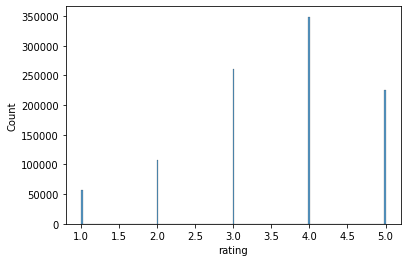

In [4]:
sns.histplot(ratings['rating'])

plt.show()

유저가 __3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외__ 한다.

In [5]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


별점 데이터는 대표적인 explicit 데이터지만 __implicit 데이터로 간주__ 하고 테스트하기 위해  
별점을 __시청횟수__ 로 해석한다.

In [6]:
# rating 컬럼의 이름을 count로 바꿈
ratings.rename(columns={'rating':'count'}, inplace=True)

`movie_id` 를 기준으로 두 데이터셋을 합친 `total` dataframe 을 생성하자.

In [7]:
total = pd.merge(ratings,movies,how='left', on=['movie_id'])
total.head()

,user_id,movie_id,count,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy


영화 장르인 `genre` 컬럼은 `Animation|Children's|Comedy` 와 같이 여러 장르가 `|` 로  이어져있으므로 분리해서 새로운 컬럼에 각각 저장한다.

In [8]:
total[['genre_1', 'genre_2', 'genre_3','genre_4','genre_5','genre_6']] = total.genre.str.split("|",expand=True)
total.head()

,user_id,movie_id,count,timestamp,title,genre,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,Drama,None,None,None,None,None
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,Animation,Children's,Musical,None,None,None
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,Musical,Romance,None,None,None,None
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,Drama,None,None,None,None,None
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,Animation,Children's,Comedy,None,None,None


----
----
## 2. 데이터 탐색 및 분석

추천 모델을 만들기 전에 데이터의 다음과 같은 기본적인 정보를 확인한다.
- 유저 수, 영화 수, 장르 수
- 유저들이 선호하는 영화, 장르
- 평균 시청횟수가 높은 영화

### 유저 수, 영화 수, 장르 수

In [9]:
# 유저 수
ratings['user_id'].nunique()

6039

In [10]:
# 영화 수
ratings['movie_id'].nunique()

3628

In [11]:
# 장르 수
total['genre_1'].nunique()

18

In [12]:
# 장르 목록
genre_list = total['genre_1'].unique()
genre_list

array(['Drama', 'Animation', 'Musical', 'Action', 'Comedy', 'Adventure',
       'Romance', "Children's", 'Thriller', 'Crime', 'Western',
       'Documentary', 'Mystery', 'Horror', 'Sci-Fi', 'Film-Noir', 'War',
       'Fantasy'], dtype=object)

### 유저들이 선호하는 영화, 장르

In [13]:
# 인기 많은 영화 Top-30
movie_count = total.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

아메리칸 뷰티, 스타워즈 등의 명작들을 많은 유저들이 시청한 것을 알 수 있다.

In [14]:
# 인기 많은 장르
total_genre = {}    # 장르 수 딕셔너리 생성
for i in genre_list:
    total_genre[i]=0

In [15]:
 # 각 장르 컬럼에 있는 값의 갯수를 모두 더함
for i in range(6):  
    genre_count = total.groupby(f'genre_{i+1}')['user_id'].count()
    for name in genre_count.index:
        total_genre[name] += genre_count[name]

In [16]:
# 내림차순으로 정렬
sorted_by_value = dict(sorted(total_genre.items(), key=lambda x: x[1], reverse=True))
sorted_by_value

{'Drama': 313261,
 'Comedy': 293891,
 'Action': 209494,
 'Thriller': 158343,
 'Sci-Fi': 126089,
 'Romance': 125927,
 'Adventure': 108818,
 'Crime': 68889,
 'War': 61226,
 "Children's": 57674,
 'Horror': 55488,
 'Animation': 37609,
 'Musical': 35661,
 'Mystery': 34417,
 'Fantasy': 29205,
 'Western': 17668,
 'Film-Noir': 17166,
 'Documentary': 7162}

In [17]:
total_genre.keys

<function dict.keys>

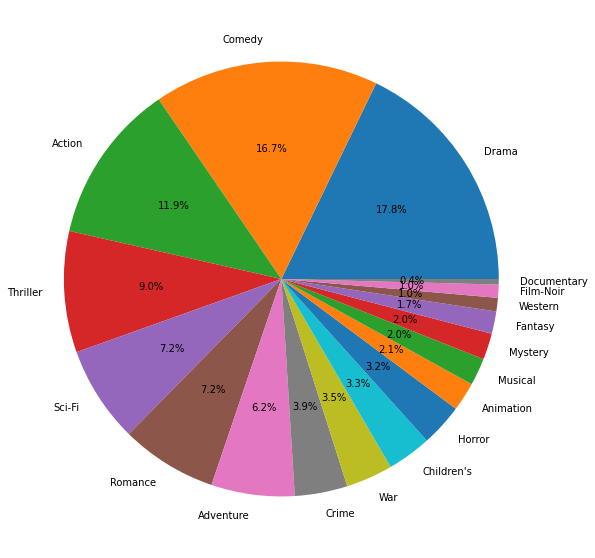

In [18]:
ratio = list(sorted_by_value.values())
labels = list(sorted_by_value.keys())

plt.figure(figsize = (10, 10))
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

드라마, 코미디, 액선 순으로 인기가 많은 것을 확인 할 수 있다.

### 평균 시청횟수가 높은 영화

In [19]:
movie_counts = pd.DataFrame(total.groupby('title')['count'].mean())
movie_counts['user_num'] = total.groupby('title')['count'].count()
movie_counts.head()

,count,user_num
title,,
"$1,000,000 Duck (1971)",3.576923,26
'Night Mother (1986),3.785714,56
'Til There Was You (1997),3.518519,27
"'burbs, The (1989)",3.575758,198
...And Justice for All (1979),3.854054,185


In [20]:
movie_counts.sort_values(by='count',ascending=False).head(10)

,count,user_num
title,,
Ulysses (Ulisse) (1954),5.0,1
Country Life (1994),5.0,1
Schlafes Bruder (Brother of Sleep) (1995),5.0,1
Foreign Student (1994),5.0,1
Follow the Bitch (1998),5.0,1
One Little Indian (1973),5.0,1
Criminal Lovers (Les Amants Criminels) (1999),5.0,1
Message to Love: The Isle of Wight Festival (1996),5.0,5
Identification of a Woman (Identificazione di una donna) (1982),5.0,1


위와 같이 평균 시청횟수가 높은 영화들 중 대부분이 소수의 유저들만 시청한 영화가 나온다.  

일반적인 정보를 얻기 위하여 100명 이상의 유저가 시청한 영화들만 나오게하자.

In [21]:
movie_counts[movie_counts['user_num']>=100].sort_values(by='count',ascending=False).head(30)

,count,user_num
title,,
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),4.629690,613
"Godfather, The (1972)",4.598523,2167
"Shawshank Redemption, The (1994)",4.596627,2194
"Usual Suspects, The (1995)",4.577982,1744
Schindler's List (1993),4.571112,2257
"Wrong Trousers, The (1993)",4.558247,867
Paths of Glory (1957),4.553571,224
"Close Shave, A (1995)",4.544479,652
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),4.539334,1322


시청한 유저수가 많으면서 높은 평균 시청 횟수를 갖는 영화들 중 대부, 쇼생크 탈출, 유주얼 서스펙트 등등의 명작 들을 다수 확인 할 수 있다.  

평균 시청 횟수 분포는 다음과 같다.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


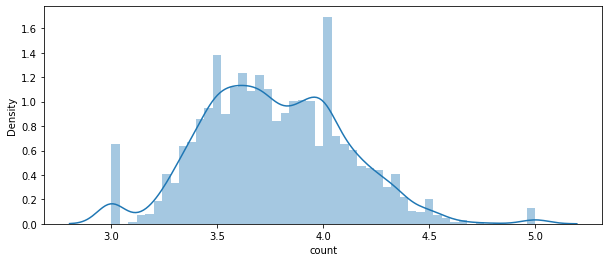

In [22]:
plt.figure(figsize = (10, 4))
sns.distplot(movie_counts['count'], bins=50)

plt.show()

----
----
## 3. 모델 검증을 위한 사용자 초기 정보 세팅


유튜브 뮤직 등 추천시스템들은 이를 위해서 처음 가입하는 사용자의 취향과 유사한 아티스트 정보를 5개 이상 입력받는 과정을 거치게 하는 경우가 많다. 이와 동일한 과정이 필요하다.

만든 추천시스템의 추후 검증 과정을 위해, 내가 선호하는 영화를 5가지 골라서 추가한 새로운 Dataframe `data_df` 를 생성하자.

In [23]:
data_df = total.copy()

필요한 칼럼만 사용한다.

In [24]:
data_df = data_df[['user_id','title', 'count']]
data_df.tail()

,user_id,title,count
836473,6040,Platoon (1986),3
836474,6040,"Crying Game, The (1992)",5
836475,6040,Welcome to the Dollhouse (1995),5
836476,6040,Sophie's Choice (1982),4
836477,6040,E.T. the Extra-Terrestrial (1982),4


### 선호하는 영화 검색
제목 검색을 위해 모두 소문자로 바꿔서 검색하는 함수 `search_movie`을 정의한다.

In [25]:
# 제목 검색을 위해 모두 소문자로 바꿔서 검색하는 함수 생성
def search_movie(name):
    return movies[movies['title'].str.lower().str.contains(name, regex=False)]

In [26]:
search_movie('silence')  # 양들의 침묵, 593

,movie_id,title,genre
125,127,"Silence of the Palace, The (Saimt el Qusur) (1...",Drama
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
1824,1893,Beyond Silence (1996),Drama


In [27]:
search_movie('leon') # 레옹, 293

,movie_id,title,genre
290,293,"Professional, The (a.k.a. Leon: The Profession...",Crime|Drama|Romance|Thriller
2826,2895,Napoleon and Samantha (1972),Adventure


In [28]:
search_movie('jumanji') # 쥬만지, 2

,movie_id,title,genre
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [29]:
search_movie('truman') # 트루먼 쇼, 1682

,movie_id,title,genre
1636,1682,"Truman Show, The (1998)",Drama


In [30]:
search_movie('good will') # 굿윌헌팅, 1704

,movie_id,title,genre
1656,1704,Good Will Hunting (1997),Drama


In [31]:
# 내가 선호하는 영화 리스트
my_favorite = {'Silence of the Lambs, The (1991)': 593, 
               'Professional, The (a.k.a. Leon: The Professional) (1994)': 293,
               'Jumanji (1995)' : 2,
               'Truman Show, The (1998)' : 1682,
               'Good Will Hunting (1997)': 1704 }

# 'jaejun' 이라는 user_id가 위 영화를 5회 시청했다고 가정
my_favorite_df = pd.DataFrame({'user_id': ['jaejun']*5, 'title': list(my_favorite.keys()), 'count':[5]*5})

if not data_df.isin({'user_id':['jaejun']})['user_id'].any():  # user_id에 'jaejun' 이라는 데이터가 없다면
    data_df = data_df.append(my_favorite_df)                           # 위에 임의로 만든 my_favorite 데이터를 추가 

data_df.tail(10)       # 잘 추가되었는지 확인

,user_id,title,count
836473,6040,Platoon (1986),3
836474,6040,"Crying Game, The (1992)",5
836475,6040,Welcome to the Dollhouse (1995),5
836476,6040,Sophie's Choice (1982),4
836477,6040,E.T. the Extra-Terrestrial (1982),4
0,jaejun,"Silence of the Lambs, The (1991)",5
1,jaejun,"Professional, The (a.k.a. Leon: The Profession...",5
2,jaejun,Jumanji (1995),5
3,jaejun,"Truman Show, The (1998)",5
4,jaejun,Good Will Hunting (1997),5


----
## 4. CSR Matrix 생성
### 모델에 활용하기 위한 전처리
데이터 관리를 쉽게 하기 위해 __indexing__ 작업을 수행한다.

In [32]:
# 고유한 유저, 타이틀를 찾아내는 코드
user_unique = data_df['user_id'].unique()
title_unique = data_df['title'].unique()

# 유저,타이틀 indexing 하는 코드 
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

# 인덱싱이 잘 되었는지 확인
print(user_to_idx['jaejun'])    # 6040명의 유저 중 마지막으로 추가된 유저이니 6039이 나와야 함

6039


In [33]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data_df['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data_df):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data_df['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')
    
# temp_title_data을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = data_df['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(data_df):
    print('title column indexing OK!!')
    data_df['title'] = temp_title_data
else:
    print('title column indexing Fail!!')


data_df

user_id column indexing OK!!
title column indexing OK!!


,user_id,title,count
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
0,6039,121,5
1,6039,890,5
2,6039,513,5
3,6039,385,5


In [34]:
from scipy.sparse import csr_matrix

num_user = data_df['user_id'].nunique()
num_movie = data_df['title'].nunique()

csr_data = csr_matrix((data_df['count'], (data_df.user_id, data_df.title)), shape=(num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Row format>

----
## 5.  AlternatingLeastSquares 모델 구성 및 훈련

### 모델 구성

In [35]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [36]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, 
                                    regularization=0.01, 
                                    use_gpu=False, 
                                    iterations=15, 
                                    dtype=np.float32)

AlternatingLeastSquares 클래스의 init 파라미터  
- `factors` : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- `regularization` : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- `use_gpu` : GPU를 사용할 것인지
- `iterations` : epochs와 같은 의미. 데이터를 몇 번 반복해서 학습할 것인지

In [37]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

### 모델 훈련

In [38]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

----
## 6. 선호도 파악
#### 내가 좋아하는 영화 선호도

내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해보자.

In [39]:
jaejun, silence = user_to_idx['jaejun'], title_to_idx['Silence of the Lambs, The (1991)']
jaejun_vector, silence = als_model.user_factors[jaejun], als_model.item_factors[silence]

In [40]:
np.dot(jaejun_vector, silence)

0.5701852

#### 내가 좋아하는 5개 영화 중 위와 다른것 선호도

In [41]:
good = title_to_idx['Good Will Hunting (1997)']
good_vector = als_model.item_factors[good]
np.dot(jaejun_vector, good_vector)

0.5279594

#### 임의의 영화 선호도

In [42]:
random= title_to_idx["Crying Game, The (1992)"]
random_vector = als_model.item_factors[random]
np.dot(jaejun_vector, random_vector) 

0.09311393

____
____

## 7. 내가 좋아하는 영화와 비슷한 영화 찾기

AlternatingLeastSquares 클래스에 구현되어 있는 `similar_items` 메서드를 통하여 내가 좋아하는 영화와 비슷한 영화를 찾아보자.  

영화 이름을 입력값으로 받아서 비슷한 영화 5개를 출력해주는 `similar_movie` 함수를 정의한다.

In [43]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict 생성
idx_to_title = {v:k for k,v in title_to_idx.items()}

def get_similar_movie(movie_name: str):
    movie_id = title_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id, N=6)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

In [44]:
get_similar_movie('Silence of the Lambs, The (1991)')

['Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)',
 'Fargo (1996)',
 'Pulp Fiction (1994)',
 "Schindler's List (1993)",
 'Good Will Hunting (1997)']

In [45]:
get_similar_movie('Professional, The (a.k.a. Leon: The Professional) (1994)')

['Professional, The (a.k.a. Leon: The Professional) (1994)',
 'Nikita (La Femme Nikita) (1990)',
 'Reservoir Dogs (1992)',
 'Seven (Se7en) (1995)',
 'Lock, Stock & Two Smoking Barrels (1998)',
 'Bound (1996)']

In [46]:
get_similar_movie('Jumanji (1995)')

['Jumanji (1995)',
 'Hook (1991)',
 'Indian in the Cupboard, The (1995)',
 'Dragonheart (1996)',
 'Flubber (1997)',
 'Santa Clause, The (1994)']

In [47]:
get_similar_movie('Truman Show, The (1998)')

['Truman Show, The (1998)',
 'Quiz Show (1994)',
 'Apollo 13 (1995)',
 "Mr. Holland's Opus (1995)",
 'Philadelphia (1993)',
 'People vs. Larry Flynt, The (1996)']

In [48]:
get_similar_movie('Good Will Hunting (1997)')

['Good Will Hunting (1997)',
 'Shawshank Redemption, The (1994)',
 'Apollo 13 (1995)',
 'Truman Show, The (1998)',
 'Dead Man Walking (1995)',
 'Awakenings (1990)']

----

## 8. 유저가 좋아하는 영화 추천
AlternatingLeastSquares 클래스에 구현되어 있는 `recommend` 메서드를 통하여 좋아할 만한 아티스트를 추천받을 수 있다.


In [49]:
user = user_to_idx['jaejun']

# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
# filter_already_liked_items 는 유저가 이미 평가한 아이템은 제외하는 Argument이다.

# 인덱스를 영화 이름으로 mapping
[idx_to_title[i[0]] for i in movie_recommended]

['Shawshank Redemption, The (1994)',
 'Fargo (1996)',
 'Pulp Fiction (1994)',
 'Apollo 13 (1995)',
 'Jerry Maguire (1996)',
 'Sixth Sense, The (1999)',
 'Usual Suspects, The (1995)',
 "Schindler's List (1993)",
 'Fight Club (1999)',
 'GoodFellas (1990)',
 'Edward Scissorhands (1990)',
 'Twelve Monkeys (1995)',
 'Trainspotting (1996)',
 'Nikita (La Femme Nikita) (1990)',
 'Rain Man (1988)',
 'Awakenings (1990)',
 'Dead Man Walking (1995)',
 'Reservoir Dogs (1992)',
 'Mask, The (1994)',
 "What's Eating Gilbert Grape (1993)"]

추천해준 영화들 중 이미 내가 재미있게 본 영화도 있고, 보고싶었던 명작들도 존재한다.  처음에 지정한 좋아하는 영화와 비슷한 장르의 영화들이 많이 추천된 것을 보아 모델이 어느정도 잘 학습 되었음을 알 수 있다.

AlternatingLeastSquares 클래스에 구현된 `explain` 메소드를 사용하면  기록을 남긴 데이터 중 이 __추천에 기여한 정도__를 확인할 수 있다.

In [50]:
shawshank = title_to_idx['Shawshank Redemption, The (1994)']
explain = als_model.explain(user, csr_data, itemid=shawshank)

[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('Silence of the Lambs, The (1991)', 0.2924966497044066),
 ('Good Will Hunting (1997)', 0.17603979286222868),
 ('Professional, The (a.k.a. Leon: The Professional) (1994)',
  0.015772424235094416),
 ('Truman Show, The (1998)', -0.005277651546851463),
 ('Jumanji (1995)', -0.012884973921571386)]

----
----

## 프로젝트 정리

Movielens 데이터를 이용하여 영화 추천시스템을 만들어보았다. 각 과정의 핵심 내용은 아래에 정리하였다.
- MovieLens 1M Dataset 에는 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있다.
- 별점 데이터는 대표적인 explicit 데이터지만 implicit 데이터로 간주하고 테스트 해볼 수 있다.
- 별점을 시청횟수 로 해석

#### 데이터 준비
- 영화 시청횟수 데이터와 영화 제목을 보기 위해 메타 데이터를 불러와 `movie_id` 컬럼을 기준으로 합침

#### 데이터 전처리
- 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외
- 영화 장르인 genre 컬럼은 `Animation|Children's|Comedy `와 같이 여러 장르가 `|` 로 이어져있으므로 분리해서 새로운 컬럼에 각각 저장

#### 데이터 탐색 및 분석
- 유저 수, 영화 수, 장르 수 등의 기본 정보 확인
- 유저들이 선호하는 영화 Top 30 확인
- 유저들이 선호하는 장르 확인 및 장르 점유율을 pie chart 로 시각화
- 평균 시청횟수가 높은 영화 확인 -> 일반적인 정보를 얻기위해 시청한 유저수가 많으면서 높은 평균 시청 횟수를 갖는 영화 확인
- 평균 시청 횟수 분포 확인

#### 모델 검증을 위한 사용자 초기 정보 세팅
- 만든 추천시스템의 추후 검증 과정을 위해, 내가 선호하는 영화를 5가지 골라서 추가한 새로운 Dataframe `data_df` 를 생성

#### 모델 구성 및 훈련
- 데이터 관리를 쉽게 하기 위한 indexing 작업
- CSR Matrix 생성
- AlternatingLeastSquares 모델 구성 및 훈련


#### 추천시스템
- 선호도 파악
>이때, 내가 선정한 영화와의 내적 값을 1와 가깝게 만들기 위해 `facotrs`를 1000으로 바꾼 결과 0.98의 거리가 나왔으나, 다른 영화들과의 내적 값이 너무 작아지는 문제가 있음  
  -> 1에 가깝게 나왔다고 이 모델이 잘 학습되었다고만은 보기 어려움
- 내가 좋아하는 영화와 비슷한 영화 찾기
- 유저가 좋아하는 영화 추천
>추천해준 영화들 중 이미 내가 재미있게 본 영화도 있고, 보고싶었던 명작들도 존재함  
  처음에 지정한 좋아하는 영화와 비슷한 장르의 영화들이 많이 추천된 것을 보아 모델이 어느정도 잘 학습 되었음을 확인함